# CS4243 Assignment 4

The goal of this assignment is to do image classification, which classifies the main scene/object of an image into a specific category.

## Assignment Guideline (Carefully Read Before Coding)

Please use **the same** environment as in assignment 3 (do **NOT** create a new environment) and install an additional package `cyvlfeat` with running this command: `conda install -c menpo cyvlfeat`. You are required to finish this notebook by successfully **(1) running all of the segments, (2) producing results and (3) answering all of the questions**. 

In this assignment, you are required to implement the key components of each step by filling the missing code segments in `image_classification.py`. You can edit `image_classification.py` with any editor/IDE (e.g. PyCharm) you are comfortable with. Before running the code segments, make sure the notebook are running in the virtual environment that you have set up. After you finish filling a code segment, make sure to save it before you run the related cells of this notebook (the notebook will automatically re-load your code in `image_classification.py`) to check if the results are correct.

### Submission Guideline

After you finish the code and get all the results, **(1) re-run this notebook including the file check in the bottom (and make sure you get all the clean outputs), (2) zip the same folder (excluding the `data` folder) back and name it with your student ID (e.g. A0123456H.zip) and (3) submit to the NUS Luminus system (in time, before 23h59 on 10 Oct 2019)**. Please be careful since any failure to follow the submission guideline will result in a grade deduction.

**Important node: Do not to include the `data` directory when zipping and uploading**

In [1]:
# Some setups
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
import os.path as osp
import pickle
from random import shuffle
from utils import *

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
#plt.rcParams['image.interpolation'] = 'linear'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

# Dataset settings
# This is the list of categories / directories to use. The categories are somewhat sorted by similarity 
# so that the confusion matrix looks more structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 
              'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest'];

# This list of shortened category names is used later for visualization
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub', 'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 
                   'Mnt', 'For'];

# Number of training examples per category to use. Max is 100. For simplicity, we assume this is the 
# number of test cases per category, as well.
num_train_per_cat = 100

# This function returns lists containing the file path for each train and test image, as well as lists 
# with the label of each train and test image. By default all four of these lists will have 1500 elements
# where each element is a string.
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths('data', categories, 
                                                                                 num_train_per_cat);

# Validating the dataset is properly founded
if len(train_image_paths) == len(test_image_paths) == 1500:
    print('Dataset loaded')
    print(f'Length of training set: {len(train_image_paths)}')
    print(f'Length of testing set: {len(test_image_paths)}')
else:
    print('Dataset loading fail')

Dataset loaded
Length of training set: 1500
Length of testing set: 1500


In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Goal: Image Classification

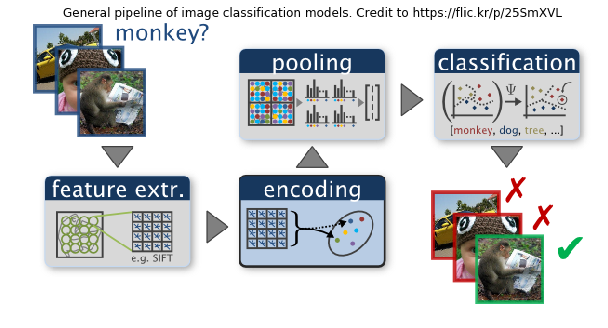

In [3]:
plt.imshow(imread('image_classification.png'))
plt.axis('off')
plt.title('General pipeline of image classification models. Credit to https://flic.kr/p/25SmXVL')
plt.show()

The goal of this project is to introduce you to image classification. Specifically, we will examine the task of scene recognition and start with simple methods -- tiny images and nearest neighbor classification -- and then move on to techniques that resemble the state-of-the-art in 2000's -- bags of quantized local features and linear classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by models used in natural language processing. The model ignores or downplays word arrangement (spatial information in the image) and classifies based on a histogram of the frequency of visual words. The visual word "vocabulary" is established by clustering a large corpus of local features. See Szeliski chapter 14.4.1 for more details on category recognition with quantized features. In addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification techniques.

In this assignment, you are required to classify scenes into one of 15 categories by training and testing on *the 15 scene database* (introduced in Lazebnik et al. 2006), as shown below:

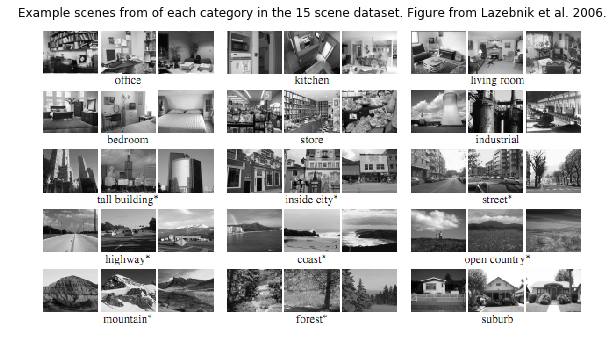

In [4]:
plt.imshow(imread('categories.png'))
plt.axis('off')
plt.title('Example scenes from of each category in the 15 scene dataset. Figure from Lazebnik et al. 2006.')
plt.show()

This assignment consists of the following parts:
1. Represent each image with the Bag-of-Visual-Words with your SIFT descriptor function in Assignment 2. (41 points incl. discussion)
    - Discussion (5 points)
    - Bonus: reimplement with your simplified SIFT in assignment 3 (additional 3 points)
2. Construct and train a nearest neighbor classifier for image recognition. ( points)
3. Use Support Vector Machines (SVMs) to obtain a better classification result. (11 points incl. discussion)
    - Discussion (5 points)
4. Use Spatial Pyramid Matching to incorporate spatial information into the model. (21 points)
    
*Note that your final marks of assignment 4 including bonus points will be capped at 100.*

## Part 1: Bag-of-Visual-Words with SIFT (47 points)

In this part, your are required to implement bags of visual words with SIFT features. Before we can represent our training and testing images as bag of feature histograms, we first need to establish a vocabulary of visual words. We will form this vocabulary by sampling many local features from our training set (10's or 100's of thousands) and then clustering them with k-means. The number of k-means clusters is the size of our vocabulary and the size of our features. For example, you might start by clustering many SIFT descriptors into k=200 clusters. This partitions the continuous, 128 dimensional SIFT feature space into 200 regions. For any new SIFT feature we observe, we can figure out which region it belongs to as long as we save the centroids of our original clusters. Those centroids are our visual word vocabulary. Because it can be slow to sample and cluster many local features, the starter code saves the cluster centroids and avoids recomputing them on future runs. 

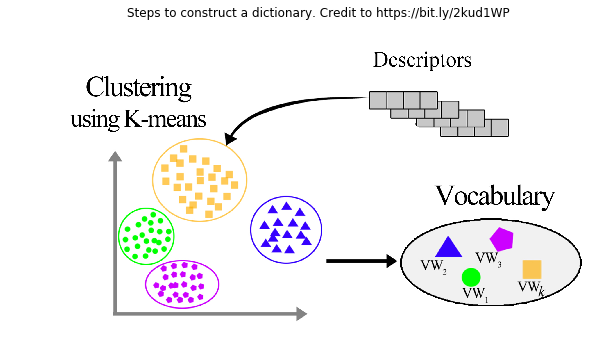

In [5]:
plt.imshow(imread('bag_of_visual_words.jpg'))
plt.axis('off')
plt.title('Steps to construct a dictionary. Credit to https://bit.ly/2kud1WP')
plt.show()

**Implement `build_vocabulary` function in `image_classification.py` to construct a visual word vocabulary from training images** (21 points). Since vocabulary only need to be generated once, we cache it for convenience. 

*-Hint: use `vlfeat.sift.dsift` to perform **dense SIFT** feature extraction and `vlfeat.kmeans.kmeans` to perform **k-means clustering**. Refer to the instruction at the beginning of the functions for more details.*

In [6]:
from image_classification import build_vocabulary

print('Using the BAG-OF-SIFT representation for images')

vocab_filename = 'vocab.pkl'
if not osp.isfile(vocab_filename):
    print('No existing visual word vocabulary found. Computing one from training images')
    vocab_size = 200  # Larger values will work better (to a point) but be slower to compute
    vocab = build_vocabulary(train_image_paths, vocab_size)
    
    with open(vocab_filename, 'wb') as f:
        pickle.dump(vocab, f)
        print('{:s} saved'.format(vocab_filename))

Using the BAG-OF-SIFT representation for images


Next, **implement `bags_of_sifts` to extract bag-of-visual-words features**, which are histograms where each bin is the number of features that is assigned to this (nearest) visual word. (21 points) Note that your histogram's visualization should be *similar to* but NOT *exactly as same as* the provided one.

***-Hint: use `scipy.spatial.distance.cdist` to compute the distances between features and visual words in the vocabulary. ***

In [7]:
from image_classification import bags_of_sifts

train_image_feats = bags_of_sifts(train_image_paths, vocab_filename)
test_image_feats = bags_of_sifts(test_image_paths, vocab_filename)

assert train_image_feats.shape[1] == test_image_feats.shape[1] == 200
print('Produced 200-dimensional feature vectors for training and testing images')

Produced 200-dimensional feature vectors for training and testing images


## Bag of sifts classifier for simple sift feature descriptor

## simple sift bag of sifts
from image_classification import build_vocab_simple

print('Using the BAG-OF-SIFT representation for images')

vocab_filename = 'vocab_simple.pkl'
if not osp.isfile(vocab_filename):
    print('No existing visual word vocabulary found. Computing one from training images')
    vocab_size = 200  # Larger values will work better (to a point) but be slower to compute
    vocab = build_vocab_simple(train_image_paths, vocab_size)
    
    with open(vocab_filename, 'wb') as f:
        pickle.dump(vocab, f)
        print('{:s} saved'.format(vocab_filename))
        

from image_classification import bags_of_sifts_simple

train_image_feats_simple = bags_of_sifts_simple(train_image_paths, vocab_filename)
test_image_feats_simple = bags_of_sifts_simple(test_image_paths, vocab_filename)

assert train_image_feats_simple.shape[1] == test_image_feats_simple.shape[1] == 200
print('Produced 200-dimensional feature vectors for training and testing images')


from image_classification import nearest_neighbor_classifier
predicted_categories_simple = nearest_neighbor_classifier(train_image_feats_simple, train_labels, test_image_feats_simple)


## Let's do some visualization on results! ##
np.random.seed(30)
vis_samples = [np.random.randint(1500) for i in range(6)]
print(vis_samples)

plt.subplot(2, 3, 1)
plt.title(f'Prediction: {predicted_categories_simple[vis_samples[0]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[0]]))

plt.subplot(2, 3, 2)
plt.title(f'Prediction: {predicted_categories_simple[vis_samples[1]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[1]]))

plt.subplot(2, 3, 3)
plt.title(f'Prediction: {predicted_categories_simple[vis_samples[2]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[2]]))

plt.subplot(2, 3, 4)
plt.title(f'Prediction: {predicted_categories_simple[vis_samples[3]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[3]]))

plt.subplot(2, 3, 5)
plt.title(f'Prediction: {predicted_categories_simple[vis_samples[4]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[4]]))

plt.subplot(2, 3, 6)
plt.title(f'Prediction: {predicted_categories_simple[vis_samples[5]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[5]]))
plt.show()


show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories,
             predicted_categories_simple)



### Discussion (5 points)

Rather than using the off-the-shelf function dense SIFT in `vlfeat`, is it possible to use the simplified version of SIFT you implemented in assignment 2? What are the possible problems? Discuss them here. *Bonus 3 points are given if you experiment with your simplified SIFT.*

#### Your answers: 

- Since the simple sift descriptor does not implement the contribution of orientation bins to neighbouring ones and does not threshold or raise to a power < 1 the resulting feature vector will not be as robust, as the vlfeat sift one.
    - Therefore using the simple_sift descriptor will lead to worse feature descriptors
- Also the code is unoptimized python code and will be multiple orders of magnitude slower than the vlfeat C code


END OF YOUR ANSWER

## Part 2: Construct and train a nearest neighbor classifier for image recognition. (21 points)


K-Nearest neighbor classifier is a simple classification technique that classify a test sample by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. If k = 1, then the sample is simply assigned to the class of that single nearest neighbor.

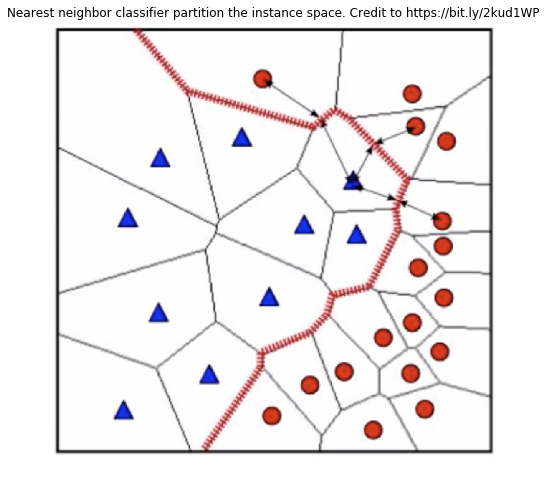

In [8]:
plt.imshow(imread('nearest_neighbor.jpg'))
plt.axis('off')
plt.title('Nearest neighbor classifier partition the instance space. Credit to https://bit.ly/2kud1WP')
plt.show()

**Implement `nearest_neighbor_classifier` to conduct k-nearest neighbor classification where k = 1**. Each function to classify test features will return an N element list, where N is the number of test cases and each entry is a string indicating the predicted category for each test image. Each entry in 'predicted_categories' must be one of the 15 strings in 'categories', 'train_labels', and 'test_labels'. See the starter code for the function for more details.

In [9]:
from image_classification import nearest_neighbor_classifier

predicted_categories = nearest_neighbor_classifier(train_image_feats, train_labels, test_image_feats)

[421, 941, 500, 1164, 919, 898]


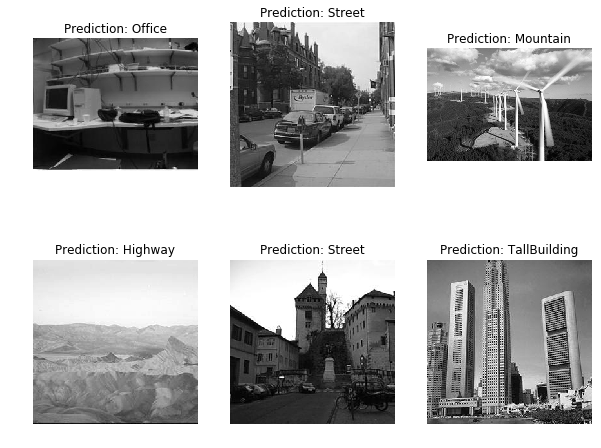

In [10]:
## Let's do some visualization on results! ##
np.random.seed(30)
vis_samples = [np.random.randint(1500) for i in range(6)]
print(vis_samples)

plt.subplot(2, 3, 1)
plt.title(f'Prediction: {predicted_categories[vis_samples[0]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[0]]))

plt.subplot(2, 3, 2)
plt.title(f'Prediction: {predicted_categories[vis_samples[1]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[1]]))

plt.subplot(2, 3, 3)
plt.title(f'Prediction: {predicted_categories[vis_samples[2]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[2]]))

plt.subplot(2, 3, 4)
plt.title(f'Prediction: {predicted_categories[vis_samples[3]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[3]]))

plt.subplot(2, 3, 5)
plt.title(f'Prediction: {predicted_categories[vis_samples[4]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[4]]))

plt.subplot(2, 3, 6)
plt.title(f'Prediction: {predicted_categories[vis_samples[5]]}')
plt.axis('off')
plt.imshow(imread(test_image_paths[vis_samples[5]]))
plt.show()

View the **confusion matrix** (that has been implemented for you) to help interpret your classifier performance. Where is it making mistakes? Are the confusions reasonable? Average classification accuracy for dense SIFT & nearest neighbor classifier should be around **50%** under our setting.

Average Accuracy: 55.47%


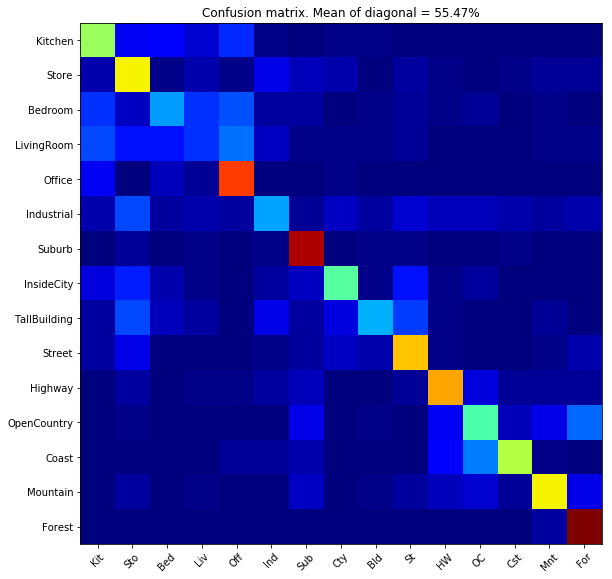

In [11]:
show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories, 
             predicted_categories)

## Part 3: Use Support Vector Machines (SVMs) to obtain a better classification result. (11 points)

A support-vector machine (SVM) constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection.

In scikit learn package, `sklearn.svm.SVC` implements the “one-against-one” classification approach (Knerr et al., 1990) for multi-class classification. Other than `sklearn.svm.SVC`, there are many more variants such as `sklearn.svm.LinearSVC`. Read more about SVM on [scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

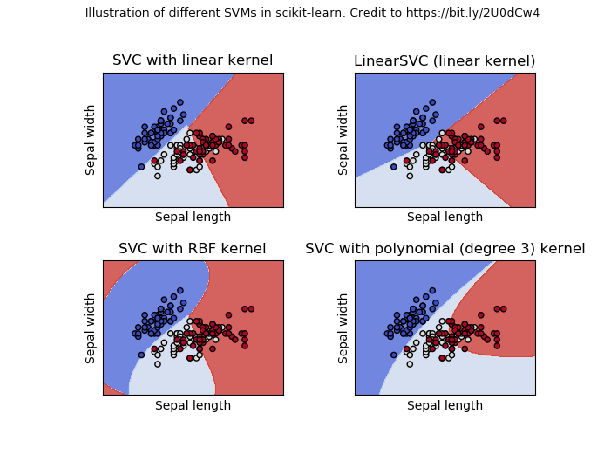

In [12]:
plt.figure(figsize=(10, 8))
plt.imshow(imread('svms.png'))
plt.axis('off')
plt.title('Illustration of different SVMs in scikit-learn. Credit to https://bit.ly/2U0dCw4')
plt.show()

You are required to implement SVM classifier by making use of SVC from sklearn library. For `sklearn.svm.SVC`, you only need to fit all training data and labels directly. 

**(6 points) Implement `svm_classify` with `sklearn.svm.SVC`. (with parameter use_svc=True).** Average classification accuracy for dense SIFT & SVC should be around **65-68%** under our setting. You may obtain higher/lower results given different hyperparameters.

Using SVM classifier to predict test set categories
Average Accuracy: 70.13%


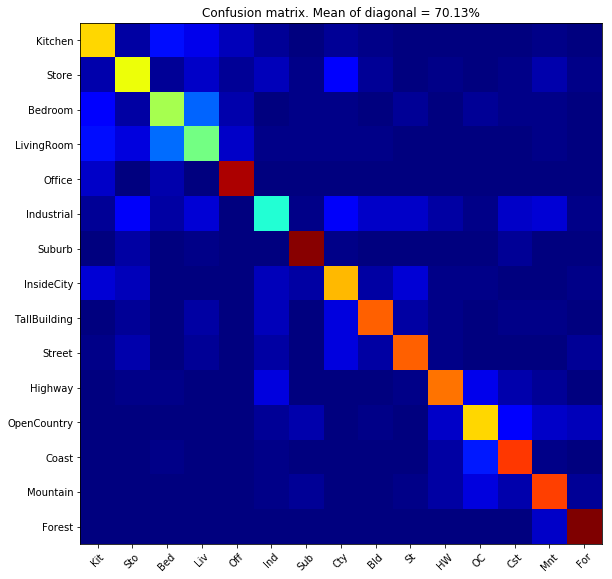

In [13]:
from image_classification import svm_classify

print('Using SVM classifier to predict test set categories')
predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)

show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories, 
             predicted_categories)

### Discussion (5 points)

Why are SVMs getting better result than nearest neighbour classifier? Discuss the possible reason(s) here.

Your answers: 

- Since the same class can be comprised of different cluster centres for the k-nearest-neighbours algorithm, picking the closest one for a feature vector might result in a missclassification if the testing sample is not very close in feature space to the training samples.
- However with an SVM since only decision planes are computed, a testing sample which is not very close to  a training sample of the same class can still be correctly classified.


END OF YOUR ANSWER

## Part 4: Use Spatial Pyramid Matching to incorporate spatial information into the model. (21 points)

One drawback that Bag of Visual Words has is, all local features are encoded into a single code vector ignoring the position of the feature descriptors, which means spatial information between words are discarded in the final code vector. Thus, to incorporate the spatial information into the final code vector, we can apply Spatial Pyramid Matching, a very simple but powerful idea proposed in [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf). 

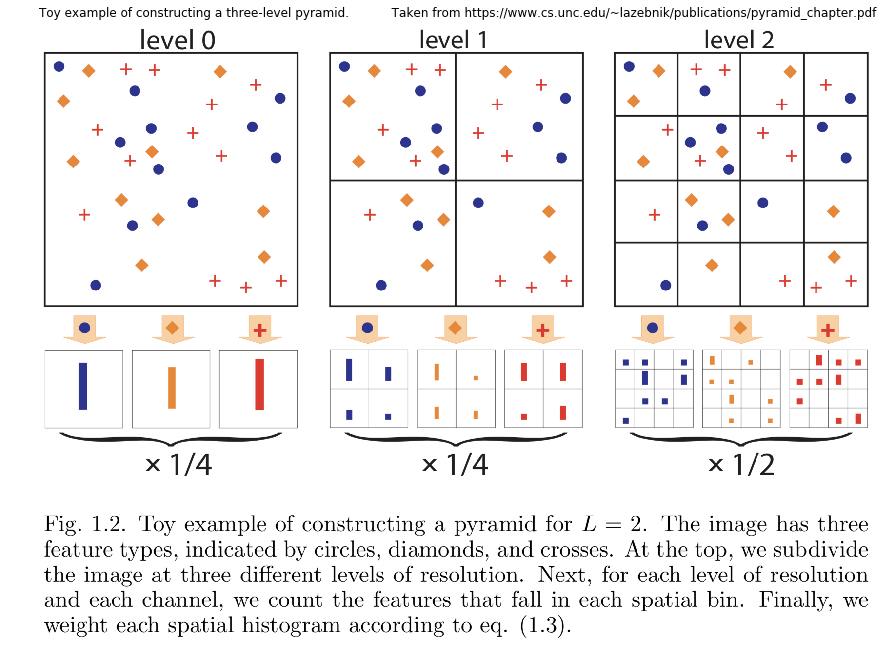

In [14]:
plt.figure(figsize=(15, 12))
plt.imshow(imread('spm.png'))
plt.axis('off')
plt.title('Toy example of constructing a three-level pyramid. \
          Taken from https://www.cs.unc.edu/~lazebnik/publications/pyramid_chapter.pdf')
plt.show()

In general, Spatial Pyramid Matching (SPM) works by performing bag-of-visual-words in different levels of *pyramid* where each has different numbers of image partitions. SPM first breaks up the image into grids. For each region, it computes the (dense) SIFT descriptor, form a histogram of visual words (weighted level-wise, see below). The histograms are then concatenated to form one single 1D vector representation. This incorporates spatial information in our image, thus can capture more features in our image and represent them in histogram form and can also result in a better performance.
<br>
<br>
That is, for each patch at each level, we compute a histogram by performing bag-of-sifts with the dictionary (vocab) in part 1, followed by a weighted process that the histograms of level $l$ is multiplied by $w_l$ is defined as follows:
$$
w_l =
\begin{cases}
    \frac{1}{2^L},& \text{if  } l = 0 \\
    \frac{1}{2^{L-l+1}},& \text{otherwise}
\end{cases}
% k^L(X, Y) = \frac{1}{2^L}\mathcal{I}^0 + \sum_{l=1}^{L} \frac{1}{2^{L-l+1}}\mathcal{I}^l,
$$
where $l$ is the current level out of $L+1$ levels ($0,1,..,L$). These histograms are then concatenated (for all the patches at all levels) to form a long feature representation. Specifically in the problem above, assume $L=2$ (3 levels: 0,1 and 2) and $M=200$ (size of our codebook = *vocab_size*), then each image is presented as a long 1D vector with the length of 4200. For more detail, refer to the section 3 (especially, section 3.2) in [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf).

**Implement `bags_of_sifts_spm` function** (18 points) that follows the process above. With the SVM implemented in the last section, the rough average accuracy should be more higher and lies in around **70-71%**. 

In [15]:
from image_classification import bags_of_sifts_spm

train_image_feats = bags_of_sifts_spm(train_image_paths, vocab_filename, depth=3)
test_image_feats = bags_of_sifts_spm(test_image_paths, vocab_filename, depth=3)

# sanity check
assert train_image_feats.shape[1] == test_image_feats.shape[1] == 4200

(1500, 4200)
(1500, 4200)


Using SVM classifier to predict test set categories
Average Accuracy: 75.80%


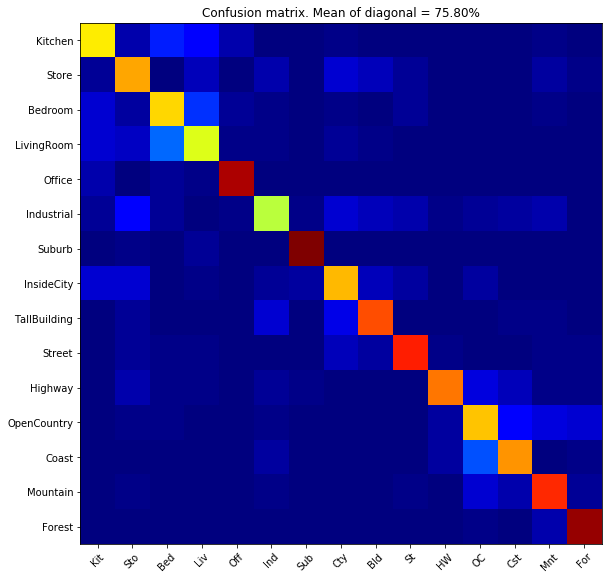

In [16]:
print('Using SVM classifier to predict test set categories')
predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)

show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories, 
             predicted_categories)

# Run the following to do a file check before making a submission

**Do not include the `data` directory when zipping and uploading.**

In [17]:
import os
required_files = ['nearest_neighbor.jpg',
                 'image_classification.py',
                 'image_classification.png',
                 'spm.png',
                 '__init__.py',
                 'utils.py',
                 'assignment4.ipynb',
                 'svms.png',
                 'bag_of_visual_words.jpg',
                 'vocab.pkl',
                 'categories.png']
files = os.listdir('.')
for file in required_files:
    if file not in files:
        raise Exception(f'File Not Exist: {file}')